# Try with DeepWalk Algorithm

In [1]:
!pip install matplotlib

In [2]:
import numpy as np
import networkx as nx
import threading
import torch.nn as nn
import torch.optim as optim
import torch
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor

Create a customed Graph

In [3]:
class Graph:
    def __init__(self, graph_dict = None, directed = False):
        self.graph_dict = graph_dict or {}
        self.directed = directed
        self.lock = threading.Lock()

        if not directed:
            self.make_undirected()

    def get_vertices(self):
        return list(self.graph_dict.keys())

    def make_adjacency_matrix(self):
        vertices = list(self.graph_dict.keys())
        shape_matrix = len(vertices)
        adj_matrix = np.zeros((shape_matrix, shape_matrix))

        for i in range(shape_matrix):
            for j in range(shape_matrix):
                if vertices[j] in self.graph_dict[vertices[i]]:
                    adj_matrix[i][j] = 1

        return adj_matrix


    def add_vertices(self, vertex):
        if vertex not in self.graph_dict:
            self.graph_dict[vertex] = []

    def add_edges(self, vertex1, vertex2):
        self.add_vertices(vertex1)
        self.add_vertices(vertex2)
        self.graph_dict[vertex1].append(vertex2)

        if not self.directed:
            self.graph_dict[vertex2].append(vertex1)

    def make_undirected(self):
        for vertex in self.graph_dict:
            for neighbor in self.graph_dict[vertex]:
                if vertex not in self.graph_dict[neighbor]:
                    self.graph_dict[neighbor].append(vertex)

    def to_networkx(self):
        if self.directed:
            G_nx = nx.DiGraph()
        else:
            G_nx = nx.Graph()

        for vertex, neighbors in self.graph_dict.items():
            G_nx.add_node(vertex)
            for neighbor in neighbors:
                G_nx.add_edge(vertex, neighbor)

        return G_nx

    def __str__(self):
        return str(self.graph_dict)



In [4]:
# G = Graph()
# G.add_vertices('A')
# G.add_vertices('B')
# G.add_vertices('C')
# G.add_vertices('D')
# G.add_vertices('E')
# G.add_vertices('F')
# G.add_vertices('G')
# G.add_vertices('H')
# G.add_edges('A', 'B')
# G.add_edges('A', 'C')
# G.add_edges('B', 'D')
# G.add_edges('C', 'E')
# G.add_edges('D', 'E')
# G.add_edges('D', 'F')
# G.add_edges('E', 'F')
# G.add_edges('E', 'G')
# G.add_edges('F', 'H')
# G.add_edges('G', 'H')
# G.add_edges('H', 'A')
# G.add_edges('H', 'B')
# G.add_edges('H', 'C')


# print(G.graph_dict)

# Create the graph
G = Graph()

# Add 16 vertices
for vertex in 'ABCDEFGHIJKLMNOP':
    G.add_vertices(vertex)

# Add edges between vertices
edges = [
    ('A', 'B'), ('A', 'C'), ('B', 'D'), ('B', 'E'), 
    ('C', 'F'), ('C', 'G'), ('D', 'H'), ('E', 'I'), 
    ('F', 'J'), ('G', 'K'), ('H', 'L'), ('I', 'M'), 
    ('J', 'N'), ('K', 'O'), ('L', 'P'), ('M', 'N'), 
    ('N', 'O'), ('O', 'P'), ('P', 'A'), ('A', 'D'),
    ('E', 'H'), ('F', 'I'), ('G', 'J'), ('H', 'K')
]

for edge in edges:
    G.add_edges(*edge)

# Print the graph dictionary
print(G.graph_dict)

{'A': ['B', 'C', 'P', 'D'], 'B': ['A', 'D', 'E'], 'C': ['A', 'F', 'G'], 'D': ['B', 'H', 'A'], 'E': ['B', 'I', 'H'], 'F': ['C', 'J', 'I'], 'G': ['C', 'K', 'J'], 'H': ['D', 'L', 'E', 'K'], 'I': ['E', 'M', 'F'], 'J': ['F', 'N', 'G'], 'K': ['G', 'O', 'H'], 'L': ['H', 'P'], 'M': ['I', 'N'], 'N': ['J', 'M', 'O'], 'O': ['K', 'N', 'P'], 'P': ['L', 'O', 'A']}


In [5]:
adj_matrix = G.make_adjacency_matrix()
print(adj_matrix)

[[0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0.]]


In [6]:
g_nx = G.to_networkx()
print(g_nx.nodes)
print(g_nx.edges)

['A', 'B', 'C', 'P', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O']
[('A', 'B'), ('A', 'C'), ('A', 'P'), ('A', 'D'), ('B', 'D'), ('B', 'E'), ('C', 'F'), ('C', 'G'), ('P', 'L'), ('P', 'O'), ('D', 'H'), ('E', 'I'), ('E', 'H'), ('F', 'J'), ('F', 'I'), ('G', 'K'), ('G', 'J'), ('H', 'L'), ('H', 'K'), ('I', 'M'), ('J', 'N'), ('K', 'O'), ('M', 'N'), ('N', 'O')]


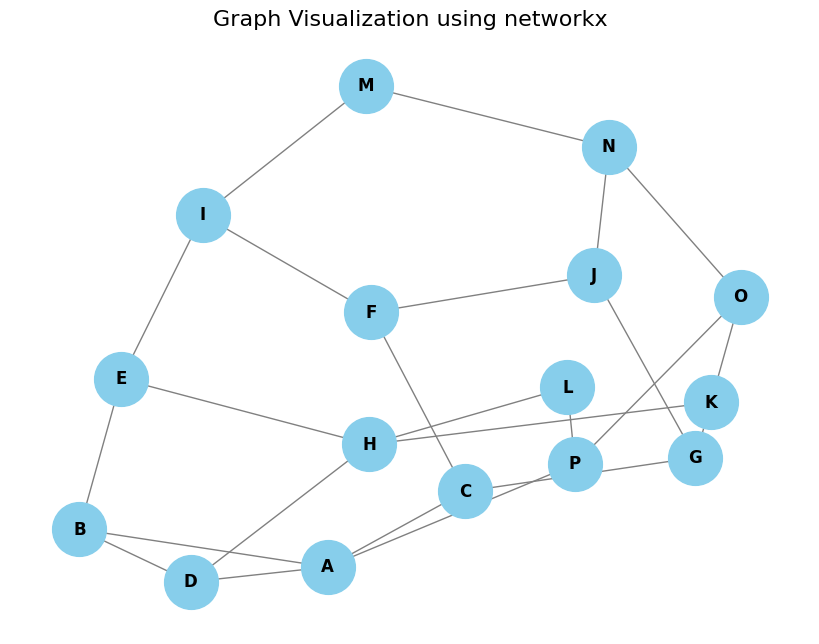

In [7]:
# Visualize the graph using networkx
plt.figure(figsize=(8, 6))
nx.draw(g_nx, with_labels=True, node_color='skyblue',
        node_size=1500, edge_color='gray', font_size=12, font_weight='bold')
plt.title("Graph Visualization using networkx", fontsize=16)
plt.show()

## Random Walk Algorithm

The random walk in DeepWalk generates sequences of nodes (analogous to sentences in NLP). These sequences capture the graph's local and global structure, which are then used for training a Skip-gram model to generate embeddings. The sequences of nodes are chosen randomly from the neighbor 
of the current node and repeat until reaches the specified length 

### Steps in Random Walk for DeepWalk

1. **Graph Initialization**  
   Input is an undirected graph $(G = (V, E))$, where $V$ represents nodes, and $E$ represents edges.

2. **Random Walk Parameters**  
   - **Walk length  $l$**: The number of steps in each random walk.
   - **Number of walks per node $k$**: How many walks to start from each node.
   - **Transition probabilities**: Uniform for a basic random walk, meaning all neighbors have an equal chance of being chosen.

3. **Generate Random Walks**  
   For each node $v_i \in V$:
   - Start a random walk at $v_i$.
   - At each step, choose $v_k$ to a randomly chosen neighbor of the current node, for which $k \in \mathcal{N}(v_i)$ and the set $\mathcal{N}(v_i)$ is the neighborhood of the vertex $v_i$.
   - Continue until the walk reaches the specified length $l$.
   
   This generates a corpus of random walks (node sequences).

4. **Train Skip-gram Model**  
   Treat the random walks as a "text corpus" and train a Skip-gram model (e.g., from Word2Vec) to learn node embeddings.

---

In [8]:
# The algorithm of the Random Algorithm 
def random_walk(graph, start_vertex, num_steps):
    """
    Performs a random walk on a graph starting from a specified vertex.

    Parameters
    ----------
    graph: Graph object
        The graph containing nodes (vertices) and edges.
    start_vertex: Any
        The starting node for the random walk.
    num_steps: int
        The number of steps the random walk should take.

    Returns
    -------
    traverse_path: list
        A list of nodes visited during the random walk.

    Raises
    ------
    ValueError
        If the start_vertex is not a valid node in the graph.
    """
    if start_vertex not in graph.graph_dict:
        return ValueError("Start vertex not in graph")

    current_vertex = start_vertex
    traverse_path = [current_vertex]

    for _ in range(num_steps):
        neighbors = graph.graph_dict[current_vertex]

        if not neighbors:
            break

        next_step = np.random.choice(neighbors)    
        traverse_path.append(next_step)
        current_vertex = next_step

    return traverse_path


# Conducting the algorithm with multi-threading to improve the performance of the model
def random_walk_multi(graph, start_vertices, num_steps, num_threads = 4):
    results = {}

    def worker(start_vertex):
        path = random_walk(graph, start_vertex, num_steps)
        with graph.lock:
            results[start_vertex] = path

    with ThreadPoolExecutor(max_workers = num_threads) as executor:
        executor.map(worker, start_vertices)

    return results


start_vertices = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
num_steps = 4
num_threads = 4

result_paths = random_walk_multi(G, start_vertices, num_steps, num_threads)
print(result_paths)

{'A': ['A', np.str_('P'), np.str_('O'), np.str_('N'), np.str_('J')], 'B': ['B', np.str_('D'), np.str_('H'), np.str_('D'), np.str_('B')], 'C': ['C', np.str_('G'), np.str_('C'), np.str_('G'), np.str_('C')], 'D': ['D', np.str_('H'), np.str_('D'), np.str_('A'), np.str_('B')], 'E': ['E', np.str_('I'), np.str_('F'), np.str_('C'), np.str_('G')], 'F': ['F', np.str_('C'), np.str_('A'), np.str_('C'), np.str_('F')], 'G': ['G', np.str_('C'), np.str_('F'), np.str_('J'), np.str_('F')], 'H': ['H', np.str_('L'), np.str_('H'), np.str_('L'), np.str_('H')]}


## Implementing the DeepWalk algorithm

These random walks sequences can be thought as the basic phrases or sentences of the graph. We can take the direct analogy to the concept of Word2Vec, which estimate the likelihood of observing the vertex $v_i$ given the the neighboring vertex $v_k$. However, the goal is to learn the latent representation $\Phi \in \mathbb{R}^{|V| \times d}$. The mapping $\Phi : v_i \in \mathbb{R} \rightarrow \mathbb{R}^{d}$ is the social representation of the vertex $v_i$.

The problem then to estimate the likelihood:

$$Pr(v_i | (\Phi(v_1), \Phi(v_2). \dots, \Phi(v_{i - 1}))$$

However, as the length of walk increases, computing the equation above is unfeasible. Hence, we have:
- Use 1 word to predict the context
- The context are the words in the left or in the right of the targeted word
- Removes the ordering constraint

Which is equivalent to the optimization problem below 
$$\underset{\Phi}{\text{minimize}} \quad - \log \Pr\left(\{v_{i-w}, \cdots, v_{i-1}, v_{i+1}, \cdots, v_{i+w}\} \mid \Phi(v_i)\right)$$

Solving this optimization captures the shared similarities in the local graph structure between vertices. It can be viewed as the sum of probabilities $P(v_k | v_i)$, which helps accelerate training. This process is known as the Skip-Gram Algorithm, a key component of the Word2Vec algorithm used in Natural Language Processing (NLP)

### Skip-Gram Algorithm

Once random walks are generated, DeepWalk applies the Skip-gram model to these sequences. In the context of DeepWalk, the Skip-gram model learns to predict the context nodes (neighbors) of a target node within a fixed-size window, based on the random walk sequences.

Given a random walk sequence:

$v_i, v_j, v_k, v_l, \dots$

For each node $v_i$ in the sequence, the Skip-gram model will learn to predict the neighboring nodes $v_i, v_j, v_k, v_l, \dots$ as its context within a fixed-size window.

Mathematically, the Skip-gram model tries to maximize the likelihood of observing the context nodes given the target node, which is the same objective as in the Word2Vec Skip-gram model:

$$P(v_j | v_i) = \frac{\exp(\Phi(v_i)^T \cdot \Phi(v_j))}{\sum_{v_k \in V} \exp(\Phi(v_i)^T \cdot \Phi(v_k))}$$




Where:

- $\Phi(v_i)$ is the vector embedding of node $v_i$
- $\Phi(v_j)$ is the vector embedding of the context node $v_j$
- $V$ is the set of all nodes in the graph.

In [9]:
def skipgram_algorithm(all_walks, window_size):

    training_data = []
    for walk in all_walks:
        for i in range(len(walk)):
            center_vertex = walk[i]

            left_start = max(0, i - window_size)
            right_end = min(len(walk), i + window_size + 1)
            for j in range(left_start, right_end):
                if i != j:
                    training_data.append((center_vertex, walk[j]))
    return training_data


In [219]:
class DeepWalk(nn.Module):
    def __init__(self, num_nodes, embedding_dim):
        super(DeepWalk, self).__init__()
        self.embeddings = nn.Embedding(num_nodes, embedding_dim)
        # self.output_layer = nn.Linear(embedding_dim, num_nodes, bias = False)

    def forward(self, center, context):
        # return self.output_layer(self.embeddings(input_walks))

        center_embed = self.embeddings(center)
        context_embed = self.embeddings(context)

        # Applying log-sum-exp trick to solve the overflow problem
        all_logits = torch.matmul(center_embed, self.embeddings.weight.T) # (B, Vocab_size)

  
        result = torch.sum(center_embed * context_embed, dim = 1, keepdim = True)
        
     
        # print(all_logits.shape)
        max_logits, _ = torch.max(all_logits, dim = 1, keepdim = True)
        log_sum_exp = max_logits + torch.log(torch.sum(torch.exp(all_logits - max_logits), dim=1, keepdim=True))
        # print(max_logits)
        log_prob = result - log_sum_exp

        return -log_prob

### Hierarchical Softmax

In [11]:
# def length_binary_tree(node):
#     count = 0
#     print(node)
#     while (node > 1):
#         node //= 2
#         count += 1
#     return count

def length_binary_tree_tensors(nodes):
    count = torch.zeros_like(nodes)
    while torch.any(nodes > 1):
        nodes = nodes // 2
        count += (nodes > 0).int()

    return count

# Example tensor input
nodes = torch.tensor(
    [23, 30, 24, 16, 28, 31, 31, 16, 31, 31, 30, 24, 25, 28, 27, 21, 
     29, 20, 26, 23, 30, 27, 29, 30, 17, 20, 30, 27, 22, 16, 17, 20], 
    device='cuda:0'
)

# Calculate lengths for each node
lengths = length_binary_tree_tensors(nodes)
print(lengths)

# length_binary_tree(6)

tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4], device='cuda:0')


In [12]:
def path_binary_tree_tensors(nodes):
    max_steps = torch.floor(torch.log2(nodes.float())).int() + 1  # Maximum path length for each node
    batch_size = len(nodes)
    
    paths = torch.zeros((batch_size, max_steps.max()), device=nodes.device, dtype=torch.int)
    
    for i in range(max_steps.max()):
        paths[:, i] = nodes
        nodes = nodes // 2  # Update nodes by dividing by 2
        nodes[nodes < 1] = 0  # Stop updating for nodes <= 1
    
    # Remove trailing zeros for each row
    path_lengths = max_steps
    # print(paths)
    trimmed_paths = torch.tensor([paths[i, :path_lengths[i]].tolist() for i in range(batch_size)])
    return trimmed_paths


nodes = torch.tensor([23, 30, 24, 16, 28], device='cuda:0')
paths = path_binary_tree_tensors(nodes)
print(paths)
for i, path in enumerate(paths):
    print(f"Path for node {i+1}: {path}")

tensor([[23, 11,  5,  2,  1],
        [30, 15,  7,  3,  1],
        [24, 12,  6,  3,  1],
        [16,  8,  4,  2,  1],
        [28, 14,  7,  3,  1]])
Path for node 1: tensor([23, 11,  5,  2,  1])
Path for node 2: tensor([30, 15,  7,  3,  1])
Path for node 3: tensor([24, 12,  6,  3,  1])
Path for node 4: tensor([16,  8,  4,  2,  1])
Path for node 5: tensor([28, 14,  7,  3,  1])


In [13]:
class DeepWalk_HierSoftmax(nn.Module):
    def __init__(self, num_nodes, embedding_dim):
        super(DeepWalk_HierSoftmax, self).__init__()
        self.num_nodes = num_nodes
        self.embeddings = nn.Embedding(num_nodes, embedding_dim)
        self.probs_tensor = nn.Parameter(torch.rand(2 * num_nodes, embedding_dim), 
                                         requires_grad = True)

    def length_binary_tree_tensors(self, nodes):
        count = torch.zeros_like(nodes)
        while torch.any(nodes > 1):
            nodes = nodes // 2
            count += (nodes > 0).int()
    
        return count

    def path_binary_tree_tensors(self, nodes):
        max_steps = torch.floor(torch.log2(nodes.float())).int() + 1  # Maximum path length for each node
        batch_size = len(nodes)
        
        paths = torch.zeros((batch_size, max_steps.max()), device=nodes.device, dtype=torch.int)
        
        for i in range(max_steps.max()):
            paths[:, i] = nodes
            nodes = nodes // 2  # Update nodes by dividing by 2
            nodes[nodes < 1] = 0  # Stop updating for nodes <= 1
        
        # Remove trailing zeros for each row
        path_lengths = max_steps
        # print(paths)
        trimmed_paths = torch.tensor([paths[i, :path_lengths[i]].tolist() for i in range(batch_size)])
        
        return trimmed_paths


    def forward(self, center, context):
        embed_center = self.embeddings(center)
        # print(f'shape of embed_center : {embed_center.shape}')
        context_node = self.num_nodes + context
        
        length_binary = self.length_binary_tree_tensors(context_node)
        path_bin_tree = self.path_binary_tree_tensors(context_node)

        # Prepare paths as a padded tensor
        max_path_len = length_binary.max()
    
        # print(max_path_len)
        logp = torch.zeros((len(context_node), 1), device=context_node.device)
        for i in range(1, max_path_len):
            # Extract the current level's nodes
            nodes = path_bin_tree[:, i]
    
            # Compute signs based on node parity
            signs = torch.where(nodes % 2 == 0, 1.0, -1.0).unsqueeze(1).to(context_node.device)

            # print(torch.matmul(self.probs_tensor[nodes], embed_center.T).shape)

            dot_product = torch.sum(self.probs_tensor[nodes] * embed_center, dim = 1, keepdim = True)

            probs = torch.sigmoid(signs * dot_product)
            
            # probs = torch.sigmoid(signs * torch.matmul(self.probs_tensor[nodes], embed_center.T))
            # print(probs)
            log_probs = torch.log(probs)
            logp += log_probs  # Aggregate probabilities for the batch
            
        return -logp


In [14]:
class DeepWalkDataset(Dataset):
    def __init__(self, training_data, vertex_to_index):
        self.training_data = training_data
        self.vertex_to_index = vertex_to_index

    def __len__(self):
        return len(self.training_data)

    def __getitem__(self, index):
        center_vertex, context_vertices = self.training_data[index]
        center_index = torch.tensor(self.vertex_to_index[center_vertex])
        context_indices = torch.tensor(self.vertex_to_index[context_vertices])

        return center_index, context_indices

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [16]:
num_walks = 30
walk_length = 5
window_size = 2
num_epochs = 5

all_walks = []
list_vertices = G.get_vertices()
for _ in range(num_walks):
    walks = random_walk_multi(G, list_vertices, walk_length)
    all_walks.extend(list(walks.values()))

# return all_walks
vertex_to_index = {vertex: index for index, vertex in enumerate(list_vertices)}
vocab_size = len(vertex_to_index)

training_data = skipgram_algorithm(all_walks, window_size)
training_data = DeepWalkDataset(training_data, vertex_to_index)
training_loader = DataLoader(training_data, batch_size = 32, shuffle = True)

deepwalk_hierarchical = DeepWalk_HierSoftmax(vocab_size, 128).to(device)
optimizer = optim.Adam(deepwalk_hierarchical.parameters(), lr = 0.001)

deepwalk_hierarchical.train()
for epoch in range(num_epochs):
    total_loss = 0
    for center, context in training_loader:
        optimizer.zero_grad()
        center = center.to(device)
        context = context.to(device)
        neg_logp = deepwalk_hierarchical(center, context)

        avg_logp = neg_logp.mean()
        avg_logp.backward()
        # for i in range(neg_logp.size(0)):
        #     neg_logp[i].backward(retain_graph=True)  # retain_graph=True allows multiple backward passes

        optimizer.step()
        total_loss += avg_logp

        # print(avg_logp)

    print(f'Epoch: {epoch + 1}, Loss: {total_loss / len(training_loader)}')



Epoch: 1, Loss: 2.534926176071167
Epoch: 2, Loss: 0.19295942783355713
Epoch: 3, Loss: 0.06626729667186737
Epoch: 4, Loss: 0.0338328592479229
Epoch: 5, Loss: 0.020749082788825035


In [17]:
embedding_weight = deepwalk_hierarchical.embeddings.weight

In [18]:
def calculate_cosine_sim(vector_0, vector_1):
    dot_product = torch.sum(vector_0 * vector_1)
    
    magnitude_0 = torch.sqrt(torch.sum(vector_0 ** 2))
    magnitude_1 = torch.sqrt(torch.sum(vector_1 ** 2))
        
    cosine_similarity = dot_product / (magnitude_0 * magnitude_1)

    return cosine_similarity.item()

vector_0 = embedding_weight[1]  # Node B
vector_1 = embedding_weight[3]  # Node D

print(calculate_cosine_sim(vector_0, vector_1))

0.11891493946313858


We can measure the cosine similarity of the node `A` and node `D` to evaluate the model

## Let's try some dataset

1. BlogCatalog Dataset

In [32]:
!wget --no-check-certificate "https://datasets.syr.edu/uploads/1283153973/BlogCatalog-dataset.zip"

--2024-12-07 07:53:34--  https://datasets.syr.edu/uploads/1283153973/BlogCatalog-dataset.zip
Resolving datasets.syr.edu (datasets.syr.edu)... 128.230.247.57
Connecting to datasets.syr.edu (datasets.syr.edu)|128.230.247.57|:443... connected.
  Issued certificate has expired.
200 OKequest sent, awaiting response... 
Length: 976987 (954K) [application/zip]
Saving to: ‘BlogCatalog-dataset.zip’

BlogCatalog-dataset 100%[===================>] 954.09K  5.93MB/s    in 0.2s    

2024-12-07 07:53:34 (5.93 MB/s) - ‘BlogCatalog-dataset.zip’ saved [976987/976987]



In [33]:
!sudo apt-get install unzip
!unzip BlogCatalog-dataset.zip

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unzip is already the newest version (6.0-26ubuntu3.2).
0 upgraded, 0 newly installed, 0 to remove and 1 not upgraded.
Archive:  BlogCatalog-dataset.zip
   creating: BlogCatalog-dataset/
   creating: BlogCatalog-dataset/data/
  inflating: BlogCatalog-dataset/data/edges.csv  
  inflating: BlogCatalog-dataset/data/group-edges.csv  
  inflating: BlogCatalog-dataset/data/groups.csv  
  inflating: BlogCatalog-dataset/data/nodes.csv  
  inflating: BlogCatalog-dataset/readme.txt  


In [30]:
!ls

BlogCatalog-dataset  BlogCatalog-dataset.zip  DeepWalk.ipynb


Loading the dataset

In [22]:
import pandas as pd
from torch.utils.data import Dataset
import networkx as nx
from tqdm.notebook import tqdm


In [182]:
nodes_df = pd.read_csv('BlogCatalog-dataset/data/nodes.csv',
                   header = None, names = ['id'])
edges_df = pd.read_csv('BlogCatalog-dataset/data/edges.csv',
                   header = None, names = ['source', 'target'])
labels_df = pd.read_csv('BlogCatalog-dataset/data/groups.csv',
                        header = None, names = ['label'])
labels_node_df = pd.read_csv('BlogCatalog-dataset/data/group-edges.csv',
                            header = None, names = ['node', 'label'])


G = nx.Graph()

for _, row in nodes_df.iterrows():
    G.add_node(row['id'])

G.add_edges_from(edges_df.values)



In [39]:
print(f'Number of labels: {groups_df.shape[0]}')
print(f'Number of nodes with labels: {label_nodes_df.shape[0]}')

Number of labels: 39
Number of nodes with labels: 14476


In [43]:
duplicated_nodes = label_nodes_df[label_nodes_df.duplicated(subset='node', keep=False)]
duplicated_nodes

,node,label
0,28,1
2,36,1
3,37,1
4,84,1
5,129,1
...,...,...
14468,14,39
14469,691,39
14470,1250,39
14473,1550,39


In [258]:
abc = label_nodes_df.groupby('node')['label'].apply(list).to_dict()
abc[1762]

[37]

In [248]:
label_nodes_df[label_nodes_df['label'] == 37]

,node,label
14388,1053,37
14389,1762,37
14390,1851,37
14391,1866,37
14392,2382,37
14393,2508,37
14394,3037,37
14395,3045,37
14396,3128,37
14397,3690,37


Meaning that there are cases where 1 node has 2 labels or more. This is generally when 1 blog can contain several information like `Science` and `Technology`, which contains 2 labels

In [48]:
# Number of nodes
print(f"Number of nodes: {len(G.nodes)}")

# Number of edges
print(f"Number of edgesVinFuture prize 2023: {len(G.edges)}")

Number of nodes: 10312
Number of edges: 333983


In [50]:
len(label_nodes_df['node'].unique())


10312

The first node id starts with 1

### Visualizing a subset of the graph

In [55]:
H.nodes

NodeView((1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220

We pick the first 500 nodes and visualize the graph

5460


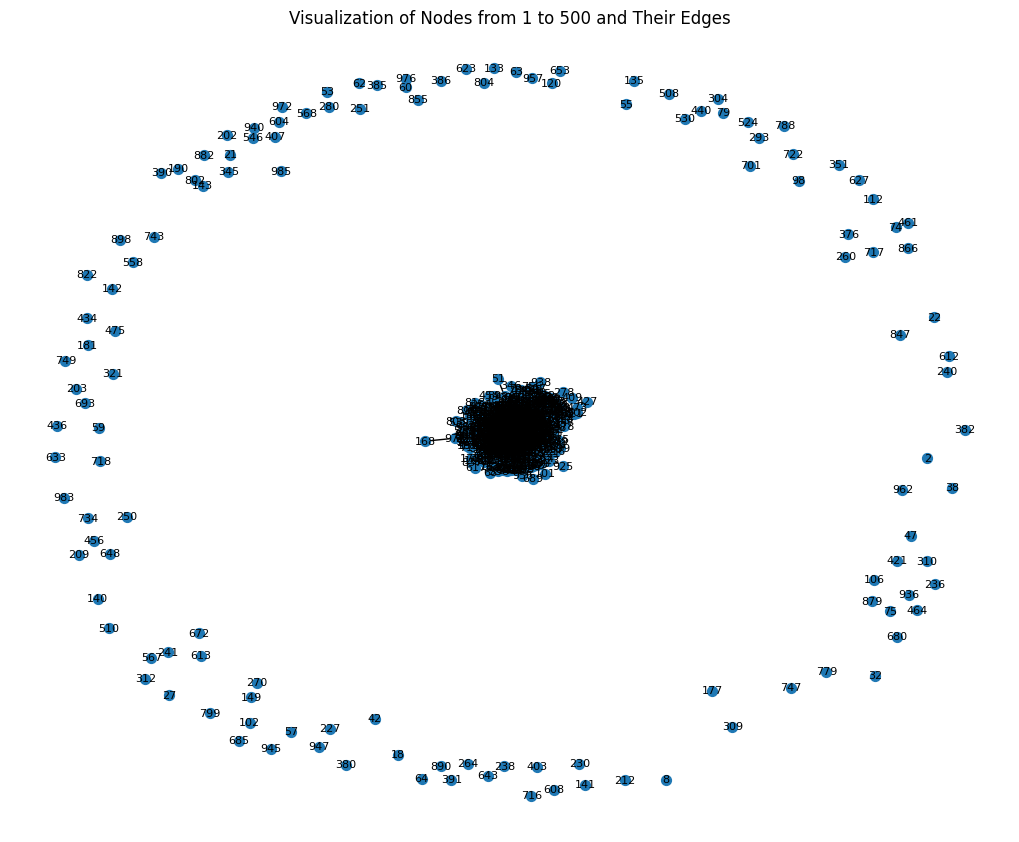

In [82]:
nodes_range = range(1000)  # Range of nodes from 0 to 100

# Create a subgraph directly
H = G.subgraph(nodes_range)

# Get the edges of the subgraph
subgraph_edges = list(H.edges)

print(len(subgraph_edges))

# Draw the filtered subgraph
plt.figure(figsize=(10, 8))
nx.draw(H, with_labels=True, node_size=50, font_size=8)
plt.title("Visualization of Nodes from 1 to 500 and Their Edges")
plt.show()


The visualization is sparse since it only display the connection the edges between the nodes in range from 1 to 500. 

In [319]:
def create_random_walk(graph, start_vertex, length = 5):

    walk = [start_vertex]
    current_vertex = start_vertex
    for _ in range(length):
        neighbors = list(graph.neighbors(current_vertex))
        if not neighbors:  # Handle case where there are no neighbors
            break
        chosen_node = np.random.choice(neighbors)
        walk.append(chosen_node)
        current_vertex = chosen_node

    return walk

# Conducting the algorithm with multi-threading to improve the performance of the model
def random_walk_multi(graph, start_vertices, num_steps, num_threads = 4):
    results = {}

    def worker(start_vertex):
        path = create_random_walk(graph, start_vertex, num_steps)
        results[start_vertex] = path

    with ThreadPoolExecutor(max_workers = num_threads) as executor:
        # executor.map(worker, start_vertices)
        list(tqdm(executor.map(worker, start_vertices), 
                  total=len(start_vertices), desc="Processing Vertices"))

        
    return results
# create_random_walk(G, 1, length = 10)

In [320]:
class DeepWalkDataset(Dataset):
    def __init__(self, training_data, vertex_to_index):
        self.training_data = training_data
        self.vertex_to_index = vertex_to_index

        self.index_to_vertex = {index: vertex for vertex, index in self.vertex_to_index.items()}
    def __len__(self):
        return len(self.training_data)

    def __getitem__(self, index):
        center_vertex, context_vertices = self.training_data[index]
        center_index = torch.tensor(self.vertex_to_index[center_vertex])
        context_indices = torch.tensor(self.vertex_to_index[context_vertices])

        return center_index, context_indices

In [321]:
num_walks = 40
walk_length = 40
window_size = 10

def random_walks_dataset(graph, num_walks, walk_length, window_size):
    # Generate Random Walks part
    all_walks = []
    list_vertices = list(graph.nodes)
    
    for i in tqdm(range(num_walks), desc="Generating Random Walks"):
        walks = random_walk_multi(graph, list_vertices, walk_length, num_threads = 10)
        all_walks.extend(list(walks.values()))

    vertex_to_index = {vertex: index for index, vertex in enumerate(list_vertices)}
    vocab_size = len(vertex_to_index)

    # Skip Gram Part
    training_data = []
    for walk in tqdm(all_walks, desc="Processing walks For Skipgram", unit="walk"):
        for i in range(len(walk)):
            center_vertex = walk[i]

            left_start = max(0, i - window_size)
            right_end = min(len(walk), i + window_size + 1)
            for j in range(left_start, right_end):
                if i != j:
                    training_data.append((center_vertex, walk[j]))

    training_data = DeepWalkDataset(training_data, vertex_to_index)

    
    return training_data

# walks_dataset = random_walks_dataset(H, num_walks, walk_length, window_size)

training_data = random_walks_dataset(G, num_walks, walk_length, window_size)

Generating Random Walks:   0%|          | 0/60 [00:00<?, ?it/s]

Processing Vertices:   0%|          | 0/10312 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [242]:
num_epochs = 10

def learning_embed(training_dataset, model, num_epochs):
    vertex2idx = training_dataset.vertex_to_index
    idx2vertex = training_dataset.index_to_vertex
    num_nodes = len(list(vertex2idx.values()))

    # print(num_nodes)
    training_loader_embed = DataLoader(training_dataset, batch_size = 32, shuffle = True)
    deepwalk = model(num_nodes, 128).to(device)
    optimizer = optim.Adam(deepwalk.parameters(), lr = 0.001)
    
    deepwalk.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for center, context in training_loader:
            optimizer.zero_grad()
            center = center.to(device)
            context = context.to(device)

            neg_logp = deepwalk(center, context)
    
            avg_logp = neg_logp.mean()
            avg_logp.backward()
            # for i in range(neg_logp.size(0)):
            #     neg_logp[i].backward(retain_graph=True)  # retain_graph=True allows multiple backward passes
    
            optimizer.step()
            total_loss += avg_logp
    
            # print(avg_logp)
    
        print(f'Epoch: {epoch + 1}, Loss: {total_loss / len(training_loader)}')

    return deepwalk

embed_model = learning_embed(training_data, DeepWalk_HierSoftmax, num_epochs)

Epoch: 1, Loss: 8.03852367401123
Epoch: 2, Loss: 0.43794989585876465
Epoch: 3, Loss: 0.148373082280159
Epoch: 4, Loss: 0.07641376554965973
Epoch: 5, Loss: 0.04680778831243515
Epoch: 6, Loss: 0.031463976949453354
Epoch: 7, Loss: 0.02240893803536892
Epoch: 8, Loss: 0.016608746722340584
Epoch: 9, Loss: 0.012672307901084423
Epoch: 10, Loss: 0.00988306850194931


In [312]:
embed_model_lol = learning_embed(training_data, DeepWalk, num_epochs)

Epoch: 1, Loss: 90.3290023803711
Epoch: 2, Loss: 63.79793167114258
Epoch: 3, Loss: 45.06209945678711
Epoch: 4, Loss: 31.806922912597656
Epoch: 5, Loss: 22.41330337524414
Epoch: 6, Loss: 15.758727073669434
Epoch: 7, Loss: 11.050331115722656
Epoch: 8, Loss: 7.756632328033447
Epoch: 9, Loss: 5.494896411895752
Epoch: 10, Loss: 3.991975784301758


### Node Classification

In this stage we will implement the Multi-Label Classification with the One-vs-Rest Logistic algorithm implemented by LibLinear 

In [243]:
embed_model.embeddings.weight.shape

torch.Size([10312, 128])

In [316]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import hamming_loss, f1_score


def node_classification(model, training_data, labels_df, labels_node_df):
    model.eval()

    idx2vertex = training_data.index_to_vertex
    vertex2idx = training_data.vertex_to_index
    print(len(vertex2idx))
    # Creating the dataset for node_classification
    # Take out the embeddings after training to Numpy
    node_embeddings = model.embeddings.weight.detach().cpu().numpy()
    # print(node_embeddings.shape)
    labels = label_nodes_df.groupby('node')['label'].apply(list).to_dict()
    print(labels[1762])
    labels_scope = {vertex: labels[vertex] for vertex in labels if vertex in vertex2idx}

    print(labels_scope[1762])
    
    # Index to label 
    idx2label = {}
    for idx, label in enumerate(labels_df['label'].unique()):
        idx2label[idx] = label

    print(idx2label)
    
    label2idx = {label: idx for idx, label in idx2label.items()} 
    num_labels = len(list(label2idx.keys()))

    num_nodes = len(list(labels_scope.keys()))
    
    Y = np.zeros((num_nodes, num_labels))
    for idx, node in idx2vertex.items():
        # print(idx, node)
        if node in labels_scope:
            for label in labels_scope.get(node, []):  
                index_label = label2idx[label]
                Y[idx, index_label] = 1

    print(Y[1762, :])
    X_train, X_test, y_train, y_test = train_test_split(node_embeddings, Y, 
                                                        test_size = 0.5, 
                                                        random_state = 42)

    
    # Train a Liblinear model for multi-label classification (binary relevance approach)
    # We'll use one Logistic Regression per label
    clf = OneVsRestClassifier(
        LogisticRegression(
            solver = "liblinear",
            max_iter = 100)
    )
        
    clf.fit(X_train, y_train)

    y_score = clf.predict_proba(X_test) 
    num_label = np.sum(y_test, axis = 1, dtype = np.int64)
    # Take the largest first and then descending
    y_sort = np.fliplr(np.argsort(y_score, axis = 1))
    y_pred = np.zeros_like(y_test, dtype=np.int64)
    
    for i in range(y_test.shape[0]):
        for j in range(num_label[i]):
            y_pred[i, y_sort[i, j]] = 1

    # Evaluate the model
    hamming = hamming_loss(y_test, y_pred)
    print(f'Test:\n', y_test)
    print(f'Predict:\n', y_pred)
    f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
    f1_micro = f1_score(y_test, y_pred, average='micro', zero_division=0)

    print(f"Hamming Loss: {hamming}")
    print(f"Macro F1 Score: {f1_macro}")
    print(f"Micro F1 Score: {f1_micro}")
    
    return hamming, f1_macro, f1_micro, y_test, y_pred

    
hamming, f1_macro, f1_micro, y_test, y_pred = node_classification(embed_model_lol, 
                                                                  training_data, 
                                                  labels_df, labels_node_df)

10312
[37]
[37]
{0: np.int64(1), 1: np.int64(2), 2: np.int64(3), 3: np.int64(4), 4: np.int64(5), 5: np.int64(6), 6: np.int64(7), 7: np.int64(8), 8: np.int64(9), 9: np.int64(10), 10: np.int64(11), 11: np.int64(12), 12: np.int64(13), 13: np.int64(14), 14: np.int64(15), 15: np.int64(16), 16: np.int64(17), 17: np.int64(18), 18: np.int64(19), 19: np.int64(20), 20: np.int64(21), 21: np.int64(22), 22: np.int64(23), 23: np.int64(24), 24: np.int64(25), 25: np.int64(26), 26: np.int64(27), 27: np.int64(28), 28: np.int64(29), 29: np.int64(30), 30: np.int64(31), 31: np.int64(32), 32: np.int64(33), 33: np.int64(34), 34: np.int64(35), 35: np.int64(36), 36: np.int64(37), 37: np.int64(38), 38: np.int64(39)}
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
Test:
 [[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]
Predict:
 [[0 0 0

In [305]:
idx2vertex = training_data.index_to_vertex
vertex2idx = training_data.vertex_to_index
print(len(vertex2idx))
# Creating the dataset for node_classification
# Take out the embeddings after training to Numpy
node_embeddings = embed_model.embeddings.weight.detach().cpu().numpy()
# print(node_embeddings.shape)
labels = label_nodes_df.groupby('node')['label'].apply(list).to_dict()
print(labels[1762])
labels_scope = {vertex: labels[vertex] for vertex in labels if vertex in vertex2idx}

print(labels_scope[1762])

# Index to label 
idx2label = {}
for idx, label in enumerate(labels_df['label'].unique()):
    idx2label[idx] = label

print(idx2label)

label2idx = {label: idx for idx, label in idx2label.items()} 
num_labels = len(list(label2idx.keys()))

num_nodes = len(list(labels_scope.keys()))

Y = np.zeros((num_nodes, num_labels))
for idx, node in idx2vertex.items():
    # print(idx, node)
    if node in labels_scope:
        for label in labels_scope.get(node, []):  
            index_label = label2idx[label]
            Y[idx, index_label] = 1

print(Y[1762, :])
X_train, X_test, y_train, y_test = train_test_split(node_embeddings, Y, 
                                                    test_size = 0.2, 
                                                    random_state = 42)


# Train a Liblinear model for multi-label classification (binary relevance approach)
# We'll use one Logistic Regression per label


10312
[37]
[37]
{0: np.int64(1), 1: np.int64(2), 2: np.int64(3), 3: np.int64(4), 4: np.int64(5), 5: np.int64(6), 6: np.int64(7), 7: np.int64(8), 8: np.int64(9), 9: np.int64(10), 10: np.int64(11), 11: np.int64(12), 12: np.int64(13), 13: np.int64(14), 14: np.int64(15), 15: np.int64(16), 16: np.int64(17), 17: np.int64(18), 18: np.int64(19), 19: np.int64(20), 20: np.int64(21), 21: np.int64(22), 22: np.int64(23), 23: np.int64(24), 24: np.int64(25), 25: np.int64(26), 26: np.int64(27), 27: np.int64(28), 28: np.int64(29), 29: np.int64(30), 30: np.int64(31), 31: np.int64(32), 32: np.int64(33), 33: np.int64(34), 34: np.int64(35), 35: np.int64(36), 36: np.int64(37), 37: np.int64(38), 38: np.int64(39)}
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


Hamming Loss: 0.06224442870104528
Macro F1 Score: 0.035145856950601545
Micro F1 Score: 0.1247815449143656


In [306]:
print(labels_scope[1763])

[8, 19, 20, 32]


In [308]:
print(X_train.shape)

(8249, 128)


In [309]:
clf = OneVsRestClassifier(
    LogisticRegression(
        solver = "liblinear",
        max_iter = 100)
)
    
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)


In [310]:
y_score = clf.predict_proba(X_test) 
num_label = np.sum(y_test, axis = 1, dtype = np.int64)
# Take the largest first and then descending
y_sort = np.fliplr(np.argsort(y_score, axis = 1))
y_pred = np.zeros_like(y_test, dtype=np.int64)

for i in range(y_test.shape[0]):
    for j in range(num_label[i]):
        y_pred[i, y_sort[i, j]] = 1

print(y_pred)

[[0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [311]:
# Evaluate the model
hamming = hamming_loss(y_test, y_pred)
print(f'Test:\n', y_test)
print(f'Predict:\n', y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_micro = f1_score(y_test, y_pred, average='micro')

print(f"Hamming Loss: {hamming}")
print(f"Macro F1 Score: {f1_macro}")
print(f"Micro F1 Score: {f1_micro}")

Test:
 [[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Predict:
 [[0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Hamming Loss: 0.061946132716854965
Macro F1 Score: 0.03940706945779105
Micro F1 Score: 0.12897588255854597


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Hamming Loss

The **Hamming Loss** is a metric used to evaluate the performance of a multi-label classification model. It measures the fraction of incorrect labels (either false positives or false negatives) assigned by the model compared to the total number of labels.

#### 1. **Definition**
Hamming Loss calculates how far the predicted labels are from the true labels on average. It considers both:

 - **False Positives (FP)**: Labels predicted as 1 but are actually 0.
 - **False Negatives (FN)**: Labels predicted as 0 but are actually 1.

The formula for Hamming Loss is:

$$\text{Hamming Loss} = \frac{1}{N \times L} \sum_{i=1}^{N} \sum_{j=1}^{L} \mathbb{1}(Y_{ij} \neq \hat{Y}_{ij})$$

Where:

- $N:$ Total number of samples (instances or rows in the dataset).
- $L:$ Total number of labels.
- $Y_{ij}:$ The true value of the $j$-th label for the $i$-th sample (0 or 1)
- $\hat{Y}_{ij}:$ The predicted value of the $j$-th label for the $i$-th sample (0 or 1).
- $1(Y_{ij} \neq \hat{Y}_{ij}):$ An indicator function that equals 1 if 
$Y_{ij} \neq \hat{Y}_{ij}$, and $0$ otherwise


#### 2. **Interpretation**
- **Hamming Loss = 0**:
    - Perfect prediction: The model's predictions perfectly match the true labels for all instances and all labels.

- **Higher Hamming Loss (closer to 1):**
    - Indicates a larger fraction of labels that were incorrectly predicted across all samples

### F1 Macro and F1 Micro

The **F1 Macro** and **F1 Micro** scores are two different ways to compute the F1 score in multi-label classification, and they focus on different aspects of model performance.

#### 1. F1 Macro
- **Definition**: The **macro F1 score** computes the F1 score for each label individually and then takes the **average** across all labels, treating all labels equally regardless of how frequent or rare they are.
- **Formula**:
$$F1_{\text{macro}} = \frac{1}{L} \sum_{l=1}^{L} F1_l$$
where $L$ is the total number of labels and $F1_l$ is the F1 score for the $l$-th label is the F1 score for the $l$-th label.

- **Use Case**:
    - F1 Macro is **label-centric**.
    - It gives equal importance to each label, making it a good choice when you are interested in the performance of the model on rare labels as well as common ones.
    - If your dataset is **imbalanced**, rare labels will have a significant impact on the macro F1 score.

#### 2. F1 Micro
- **Definition**: The **micro F1 score** aggregates contributions from all labels and computes the F1 score globally by treating the problem as a single multi-class task.
- **Formula**:
$$F1_{\text{micro}} = \frac{2 \times \text{Precision}_{\text{micro}} \times \text{Recall}_{\text{micro}}}{\text{Precision}_{\text{micro}} + \text{Recall}_{\text{micro}}}
$$

Here, **micro Precision** and **micro Recall** are computed by summing up the true positives, false positives, and false negatives across all labels.

- **Use Case**:
    - F1 Micro is **sample-centric**.
    - It is influenced more by the performance on frequent labels because frequent labels contribute more to the overall count of true positives, false positives, and false negatives.
    - This makes it a good choice when you want an overall measure of how well the model is performing across all labels.